In [326]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
import matplotlib.pyplot as plt



# Metodo Random Forest

In [313]:
df = pd.read_csv("./train.csv")


In [314]:
def mean_target_encoding(train, nombrefeat, nombretarget):
        
    temp = train.groupby(nombrefeat)[nombretarget].transform(np.mean) #Saco promedio
    temp = preprocessing.scale(temp) #Normalizo
    train[nombrefeat + "_mean"] = temp #Dejo en el DF
    
    return train


In [315]:
def mean_target_decoding(x_test, nombrefeat, x_train):
    
    nombrefeatmean = nombrefeat + "_mean"
    
    temp = x_train.loc[:,[nombrefeat,nombrefeatmean]]
    temp = temp.set_index(nombrefeat)
    temp = temp.drop_duplicates()
    temp = temp.T.squeeze()
    values = x_test[nombrefeat].map(temp)
    x_test[nombrefeatmean] = values 

    return x_test

In [316]:
df['agregados']= df['escuelascercanas']+df['gimnasio']+df['centroscomercialescercanos']+df['piscina']+df['usosmultiples']
train = df.drop(['id','idzona','lat','direccion','descripcion','titulo','lng', 'escuelascercanas','gimnasio','centroscomercialescercanos','piscina','usosmultiples'],1)
train['fecha'] = pd.to_datetime(train['fecha']).dt.year
train.fillna(0, inplace=True)
X = train
y = train['precio']

from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

#X_train = mean_target_encoding(X_train, "tipodepropiedad", "precio")
X_train = mean_target_encoding(X_train, "provincia", "precio")
X_train = mean_target_encoding(X_train, "ciudad", "precio")

X_test = mean_target_decoding(X_test, "provincia", X_train)
#X_test = mean_target_decoding(X_test, "tipodepropiedad", X_train)
X_test = mean_target_decoding(X_test, "ciudad", X_train)

X_train = X_train.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 
X_train.fillna(0, inplace=True)
X_test = X_test.drop(['precio','tipodepropiedad','provincia','ciudad'],1) 
X_test.fillna(0, inplace=True)

/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/belu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

In [288]:
# Crear el modelo 
forest = RandomForestRegressor(n_estimators= 74, min_samples_split=10,min_samples_leaf=4,max_features= "sqrt",max_depth=42,bootstrap = False, verbose=2)
#Lo entreno 
forest.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 74
building tree 2 of 74
building tree 3 of 74
building tree 4 of 74
building tree 5 of 74
building tree 6 of 74
building tree 7 of 74
building tree 8 of 74
building tree 9 of 74
building tree 10 of 74
building tree 11 of 74
building tree 12 of 74
building tree 13 of 74
building tree 14 of 74
building tree 15 of 74
building tree 16 of 74
building tree 17 of 74
building tree 18 of 74
building tree 19 of 74
building tree 20 of 74
building tree 21 of 74
building tree 22 of 74
building tree 23 of 74
building tree 24 of 74
building tree 25 of 74
building tree 26 of 74
building tree 27 of 74
building tree 28 of 74
building tree 29 of 74
building tree 30 of 74
building tree 31 of 74
building tree 32 of 74
building tree 33 of 74
building tree 34 of 74
building tree 35 of 74
building tree 36 of 74
building tree 37 of 74
building tree 38 of 74
building tree 39 of 74
building tree 40 of 74
building tree 41 of 74
building tree 42 of 74
building tree 43 of 74
building tree 44 of 

[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    5.5s finished


RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=42,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=74,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=2, warm_start=False)

In [289]:
Y_pred_forest = forest.predict(X_test)
print('MAE: ', metrics.mean_absolute_error(y_test, Y_pred_forest))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


MAE:  657315.953644291


[Parallel(n_jobs=1)]: Done  74 out of  74 | elapsed:    2.7s finished


### Random search de hiperparametros

In [317]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1100, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num =15)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 3,4]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [10, 87, 165, 243, 321, 399, 477, 555, 632, 710, 788, 866, 944, 1022, 1100], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 17, 24, 31, 38, 45, 52, 60, 67, 74, 81, 88, 95, 102, 110, None], 'min_samples_split': [2, 5, 3, 4], 'min_samples_leaf': [1, 2, 4, 6], 'bootstrap': [True, False]}


In [318]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, random_state=42)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[CV] n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True, total=   0.9s
[CV] n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True, total=   0.8s
[CV] n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=102, bootstrap=True, total=   0.8s
[CV] n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  27.9s
[CV] n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  27.2s
[CV] n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=632, min_sam

[CV]  n_estimators=710, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=  14.0s
[CV] n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  33.9s
[CV] n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  34.0s
[CV] n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=866, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  34.1s
[CV] n_estimators=10, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=True 
[CV]  n_estimators=10, min_samp

[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False, total= 2.1min
[CV] n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False, total= 2.1min
[CV] n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False, total= 2.1min
[CV] n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, total=  16.3s
[CV] n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 
[CV]  n_estimators=321,

[CV]  n_estimators=10, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=95, bootstrap=True, total=   0.7s
[CV] n_estimators=10, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=95, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=95, bootstrap=True, total=   0.7s
[CV] n_estimators=555, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=False 
[CV]  n_estimators=555, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=False, total= 1.5min
[CV] n_estimators=555, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=False 
[CV]  n_estimators=555, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=False, total= 1.5min
[CV] n_estimators=555, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=False 
[CV]  n_estimators=555, min_sample

[CV]  n_estimators=87, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=45, bootstrap=True, total=   3.1s
[CV] n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True, total=  60.0s
[CV] n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True, total= 1.0min
[CV] n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=102, bootstrap=True, total= 1.0min
[CV] n_estimators=710, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=710, min_

[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=95, bootstrap=False, total=  25.1s
[CV] n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=95, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=95, bootstrap=False, total=  25.1s
[CV] n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=95, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=95, bootstrap=False, total=  25.2s
[CV] n_estimators=87, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=87, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False, total=  12.4s
[CV] n_estimators=87, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=87, min_samp

[CV]  n_estimators=1022, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=True, total= 1.6min
[CV] n_estimators=1022, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=True 
[CV]  n_estimators=1022, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=True, total= 1.6min
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=81, bootstrap=False, total=  36.4s
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=81, bootstrap=False, total=  36.8s
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=6, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=321, min_

[CV]  n_estimators=477, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True, total=  16.9s
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  42.1s
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  42.2s
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=110, bootstrap=False, total=  42.2s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=10, 

[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False, total=  25.8s
[CV] n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False, total=  25.9s
[CV] n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False, total=  25.9s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=102, bootstrap=True, total=   0.9s
[CV] n_estimators=10, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=102, bootstrap=True 
[CV]  n_estimators=10, min_samp

[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False, total= 1.1min
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=17, bootstrap=False, total= 1.1min
[CV] n_estimators=788, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False, total= 1.9min
[CV] n_estimators=788, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False, total= 1.9min
[CV] n_estimators=788, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=788, min_

[CV]  n_estimators=165, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=110, bootstrap=True, total=  12.1s
[CV] n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False, total=  44.4s
[CV] n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False, total=  44.8s
[CV] n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=67, bootstrap=False, total=  44.7s
[CV] n_estimators=165, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=165, min

[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  43.1s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  43.1s
[CV] n_estimators=1100, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=17, bootstrap=False, total=  43.1s
[CV] n_estimators=477, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=95, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=95, bootstrap=True, total=  13.1s
[CV] n_estimators=477, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=95, bootstrap=True 
[CV]  n_estimators=477, mi

[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=6, max_features=auto, max_depth=88, bootstrap=True, total= 1.1min
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=6, max_features=auto, max_depth=88, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=6, max_features=auto, max_depth=88, bootstrap=True, total= 1.1min
[CV] n_estimators=399, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=True, total=  31.1s
[CV] n_estimators=399, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=True, total=  31.3s
[CV] n_estimators=399, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=399, min_samples_

[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=True, total=  15.7s
[CV] n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False, total=   3.9s
[CV] n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False, total=   3.9s
[CV] n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=87, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False, total=   3.9s
[CV] n_estimators=1022, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=52, bootstrap=True 
[CV]  n_estimators=1022, min_sample

[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True, total=  15.5s
[CV] n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True, total=  15.9s
[CV] n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True, total=  17.0s
[CV] n_estimators=555, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=555, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, total= 1.2min
[CV] n_estimators=555, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=555, min_sampl

[CV]  n_estimators=710, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False, total= 1.6min
[CV] n_estimators=710, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False 
[CV]  n_estimators=710, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=24, bootstrap=False, total= 1.7min
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True, total=  15.7s
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True, total=  15.2s
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=399, min_sampl

[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=52, bootstrap=False, total=  48.2s
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False, total= 2.3min
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False, total= 2.3min
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=38, bootstrap=False, total= 2.3min
[CV] n_estimators=243, min_samples_split=3, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=False 
[CV]  n_estimators=243, min_

[CV]  n_estimators=866, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=  27.8s
[CV] n_estimators=866, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=866, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=  27.7s
[CV] n_estimators=866, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True 
[CV]  n_estimators=866, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=17, bootstrap=True, total=  27.7s
[CV] n_estimators=1022, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=95, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=95, bootstrap=False, total= 1.2min
[CV] n_estimators=1022, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=95, bootstrap=False 
[CV]  n_estimators=1022, min_s

[CV]  n_estimators=1100, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False, total= 2.7min
[CV] n_estimators=1100, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=45, bootstrap=False, total= 2.7min
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=88, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=88, bootstrap=False, total= 2.3min
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=88, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=88, bootstrap=False, total= 2.3min
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=88, bootstrap=False 
[CV]  n_estimators=944, m

[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=45, bootstrap=False, total=   0.4s
[CV] n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True, total=  47.2s
[CV] n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True, total=  50.9s
[CV] n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True 
[CV]  n_estimators=632, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=24, bootstrap=True, total=  47.9s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=81, bootstrap=True 
[CV]  n_estimators=10, min_samples_sp

[CV]  n_estimators=477, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=True, total=  14.3s
[CV] n_estimators=477, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=True, total=  14.3s
[CV] n_estimators=477, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=True, total=  14.3s
[CV] n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=67, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=67, bootstrap=True, total=  16.1s
[CV] n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=67, bootstrap=True 
[CV]  n_estimators=165, min_samples_

[CV]  n_estimators=866, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False, total= 1.6min
[CV] n_estimators=866, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False 
[CV]  n_estimators=866, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False, total= 1.6min
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False, total=   0.5s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False, total=   0.5s
[CV] n_estimators=10, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=10, min_sample

[CV]  n_estimators=555, min_samples_split=3, min_samples_leaf=6, max_features=auto, max_depth=74, bootstrap=False, total= 1.1min
[CV] n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True, total=  42.3s
[CV] n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True, total=  42.5s
[CV] n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True, total=  42.6s
[CV] n_estimators=632, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=632, min_sampl

[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True, total=  19.5s
[CV] n_estimators=555, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True 
[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True, total=  19.6s
[CV] n_estimators=555, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True 
[CV]  n_estimators=555, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=67, bootstrap=True, total=  19.6s
[CV] n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   8.7s
[CV] n_estimators=165, min_samples_split=4, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=165, min_samples_

[CV]  n_estimators=1100, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False, total=  49.0s
[CV] n_estimators=1100, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=74, bootstrap=False, total=  49.0s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=67, bootstrap=False, total=  58.3s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=67, bootstrap=False, total=  58.7s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=67, bootstrap=False 
[CV]  n_estimators=477, m

[CV]  n_estimators=1022, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True, total= 1.3min
[CV] n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True, total=  15.5s
[CV] n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True, total=  15.6s
[CV] n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True 
[CV]  n_estimators=165, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=74, bootstrap=True, total=  15.6s
[CV] n_estimators=87, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=74, bootstrap=True 
[CV]  n_estimators=87, min_samples_s

[CV]  n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total= 1.3min
[CV] n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total= 1.3min
[CV] n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True 
[CV]  n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=True, total= 1.3min
[CV] n_estimators=477, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False, total=  19.6s
[CV] n_estimators=477, min_samples_split=3, min_samples_leaf=6, max_features=sqrt, max_depth=74, bootstrap=False 
[CV]  n_estimators=477, min_sampl

[CV]  n_estimators=944, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False, total= 1.8min
[CV] n_estimators=944, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=False, total= 1.8min
[CV] n_estimators=555, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=88, bootstrap=False 
[CV]  n_estimators=555, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=88, bootstrap=False, total=  30.1s
[CV] n_estimators=555, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=88, bootstrap=False 
[CV]  n_estimators=555, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=88, bootstrap=False, total=  30.1s
[CV] n_estimators=555, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=88, bootstrap=False 
[CV]  n_estimators=555, min_

[CV]  n_estimators=632, min_samples_split=2, min_samples_leaf=6, max_features=auto, max_depth=67, bootstrap=True, total=  46.0s
[CV] n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False, total= 2.5min
[CV] n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False, total= 2.5min
[CV] n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=45, bootstrap=False, total= 2.5min
[CV] n_estimators=632, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=110, bootstrap=True 
[CV]  n_estimators=632,

[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True, total=  28.2s
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True, total=  28.3s
[CV] n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True, total=  28.4s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False, total= 2.2min
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=38, bootstrap=False 
[CV]  n_estimators=1100, min_s

[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=31, bootstrap=True, total=   0.9s
[CV] n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=31, bootstrap=True 
[CV]  n_estimators=10, min_samples_split=3, min_samples_leaf=2, max_features=auto, max_depth=31, bootstrap=True, total=   0.9s
[CV] n_estimators=866, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=866, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True, total=  25.7s
[CV] n_estimators=866, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=866, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True, total=  26.0s
[CV] n_estimators=866, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=866, min_samples_spl

[CV]  n_estimators=477, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=None, bootstrap=False, total=  54.2s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  57.8s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  57.6s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True, total=  57.6s
[CV] n_estimators=866, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=866, min

[CV]  n_estimators=243, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=31, bootstrap=False, total=  27.5s
[CV] n_estimators=243, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=31, bootstrap=False 
[CV]  n_estimators=243, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=31, bootstrap=False, total=  27.8s
[CV] n_estimators=243, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=31, bootstrap=False 
[CV]  n_estimators=243, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=31, bootstrap=False, total=  27.6s
[CV] n_estimators=1022, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=True 
[CV]  n_estimators=1022, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=True, total= 1.7min
[CV] n_estimators=1022, min_samples_split=3, min_samples_leaf=1, max_features=auto, max_depth=95, bootstrap=True 
[CV]  n_estimators=1022, min

[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=True, total= 1.1min
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=52, bootstrap=True, total= 1.2min
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=True, total= 1.2min
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=True 
[CV]  n_estimators=944, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=True, total= 1.2min
[CV] n_estimators=944, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=True 
[CV]  n_estimators=944, min_samples_

[CV]  n_estimators=866, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=17, bootstrap=True, total= 1.2min
[CV] n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False, total=  14.3s
[CV] n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False, total=  14.3s
[CV] n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=102, bootstrap=False, total=  14.4s
[CV] n_estimators=243, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=243

[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   9.5s
[CV] n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   9.4s
[CV] n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=477, min_samples_split=4, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   9.5s
[CV] n_estimators=399, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  36.3s
[CV] n_estimators=399, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=399, min_sa

[CV]  n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=81, bootstrap=True, total=  31.5s
[CV] n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=81, bootstrap=True 
[CV]  n_estimators=710, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=81, bootstrap=True, total=  31.5s
[CV] n_estimators=1022, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=False, total= 2.1min
[CV] n_estimators=1022, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=1022, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=False, total= 2.1min
[CV] n_estimators=1022, min_samples_split=4, min_samples_leaf=4, max_features=auto, max_depth=81, bootstrap=False 
[CV]  n_estimators=1022, m

[CV]  n_estimators=321, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=None, bootstrap=True, total=  23.7s
[CV] n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True, total=  31.2s
[CV] n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True, total=  31.3s
[CV] n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=3, min_samples_leaf=4, max_features=auto, max_depth=52, bootstrap=True, total=  31.5s
[CV] n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=788, min_samp

[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=81, bootstrap=False, total=  48.0s
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=81, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=81, bootstrap=False, total=  48.1s
[CV] n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=81, bootstrap=False 
[CV]  n_estimators=944, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=81, bootstrap=False, total=  48.2s
[CV] n_estimators=243, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=False 
[CV]  n_estimators=243, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=False, total=  29.7s
[CV] n_estimators=243, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=31, bootstrap=False 
[CV]  n_estimators=243, min_

[CV]  n_estimators=788, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=31, bootstrap=False, total=  35.0s
[CV] n_estimators=788, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=3, min_samples_leaf=4, max_features=sqrt, max_depth=31, bootstrap=False, total=  35.1s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  19.5s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=477, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  19.5s
[CV] n_estimators=477, min_samples_split=2, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=477, min_

[CV]  n_estimators=321, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=31, bootstrap=True, total=  11.3s
[CV] n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  32.1s
[CV] n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  32.2s
[CV] n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False 
[CV]  n_estimators=788, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=31, bootstrap=False, total=  32.3s
[CV] n_estimators=710, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=81, bootstrap=True 
[CV]  n_estimators=710, min_sa

[CV]  n_estimators=243, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False, total=  13.8s
[CV] n_estimators=243, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=243, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False, total=  13.9s
[CV] n_estimators=243, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False 
[CV]  n_estimators=243, min_samples_split=4, min_samples_leaf=1, max_features=sqrt, max_depth=102, bootstrap=False, total=  14.0s
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=45, bootstrap=True 
[CV]  n_estimators=1100, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=45, bootstrap=True, total= 1.3min
[CV] n_estimators=1100, min_samples_split=5, min_samples_leaf=6, max_features=auto, max_depth=45, bootstrap=True 
[CV]  n_estimators=1100

[CV]  n_estimators=710, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=45, bootstrap=True, total=  19.6s
[CV] n_estimators=710, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=45, bootstrap=True 
[CV]  n_estimators=710, min_samples_split=4, min_samples_leaf=6, max_features=sqrt, max_depth=45, bootstrap=True, total=  19.6s
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=67, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=67, bootstrap=True, total=  10.9s
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=67, bootstrap=True 
[CV]  n_estimators=399, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=67, bootstrap=True, total=  11.0s
[CV] n_estimators=399, min_samples_split=5, min_samples_leaf=6, max_features=sqrt, max_depth=67, bootstrap=True 
[CV]  n_estimators=399, min_samples_

[CV]  n_estimators=1022, min_samples_split=4, min_samples_leaf=2, max_features=auto, max_depth=74, bootstrap=False, total= 2.4min
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False, total=  14.2s
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False, total=  14.3s
[CV] n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=45, bootstrap=False, total=  14.3s
[CV] n_estimators=165, min_samples_split=4, min_samples_leaf=4, max_features=sqrt, max_depth=95, bootstrap=True 
[CV]  n_estimators=165, min_

[CV]  n_estimators=321, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, total=  16.8s
[CV] n_estimators=321, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, total=  16.9s
[CV] n_estimators=321, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False 
[CV]  n_estimators=321, min_samples_split=3, min_samples_leaf=2, max_features=sqrt, max_depth=38, bootstrap=False, total=  16.9s


[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed: 1046.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [319]:
rf_random.best_params_

{'n_estimators': 788,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 38,
 'bootstrap': True}

In [320]:
Y_pred_forest_r = rf_random.predict(X_test)
print('MAE: ', metrics.mean_absolute_error(y_test, Y_pred_forest_r))

MAE:  651742.520530638


## Regresion lineal multivariable

In [321]:
 #Defino el algoritmo a utilizar
regresion_lineal = linear_model.LinearRegression()
#Entreno el modelo
regresion_lineal.fit(X_train, y_train)

    
#Realizo una predicción
Y_pred_resgresion = regresion_lineal.predict(X_test)

print('DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE')
print('Valor de las pendientes o coeficientes "a":')
print(regresion_lineal.coef_)
print('Valor de la intersección o coeficiente "b":')
print(regresion_lineal.intercept_)


DATOS DEL MODELO REGRESIÓN LINEAL MULTIPLE
Valor de las pendientes o coeficientes "a":
[ -8494.26844679 -16138.41105486 -29606.59143455 188658.24503782
   7146.3813419    2912.13666132 141853.58864386  46458.57070497
 254018.50353968 849527.44648822]
Valor de la intersección o coeficiente "b":
-285082873.659858


In [322]:
print('Precisión del modelo:')
print(regresion_lineal.score(X_train, y_train))

Precisión del modelo:
0.501186919704498


In [323]:
print('MAE: ', metrics.mean_absolute_error(y_test, Y_pred_resgresion))

MAE:  1014675.3974346732


## Regresion + forest

In [353]:
solucion = ( Y_pred_resgresion*0.2+Y_pred_forest*0.8)
solucion

array([3060002.79454782, 1814940.80681937, 5734921.01195368, ...,
       2345211.842036  , 4136037.49254139, 1628179.47913661])

In [354]:
print('MAE: ', metrics.mean_absolute_error(y_test, solucion))

MAE:  687966.3402888149


# Regresion solo con metros cubiertos 

In [349]:
a_train = X_train.drop(['antiguedad','habitaciones','fecha','banos','metrostotales','agregados','provincia_mean','ciudad_mean'],1)
a_test = X_test.drop(['antiguedad','habitaciones','fecha','banos','metrostotales','agregados','provincia_mean','ciudad_mean'],1)

#Defino el algoritmo a utilizar
regresion_lineal = linear_model.LinearRegression()
#Entreno el modelo
regresion_lineal.fit(a_train, y_train)

    
#Realizo una predicción
Y_pred_resgresions = regresion_lineal.predict(a_test)

print('DATOS DEL MODELO REGRESIÓN')
print('Valor de las pendientes o coeficientes "a":')
print(regresion_lineal.coef_)
print('Valor de la intersección o coeficiente "b":')
print(regresion_lineal.intercept_)

DATOS DEL MODELO REGRESIÓN
Valor de las pendientes o coeficientes "a":
[83478.50570148  9973.43796471]
Valor de la intersección o coeficiente "b":
813960.7533520274


In [350]:
print('MAE: ', metrics.mean_absolute_error(y_test, Y_pred_resgresions))

MAE:  1294707.8950924324


In [355]:
#Da un mae muy alto habria que optimizar y ver que pasa

# Features 

Text(0, 0.5, 'Score')

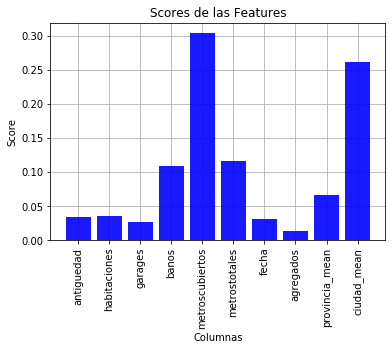

In [341]:
columnas = X_train.columns
k_utilizado = np.arange(15)
scores = forest.feature_importances_
plt.grid()
plt.xticks(k_utilizado, columnas, rotation=90)
plt.bar(columnas, scores, color = 'blue', align='center', alpha=0.9, zorder =3)
plt.title("Scores de las Features")
plt.xlabel("Columnas")
plt.ylabel("Score")